In [1]:
from __future__ import print_function, division

import pandas as pd
import numpy as np

from glob import glob
import os
from lxml import etree

import urllib

from time import sleep

from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

In [2]:
%matplotlib inline

In [2]:
Coding = 'utf-8'

In [2]:
PATH = '/home/endi/Desktop/work/Performance Score'

# Download f24 xml match

In [4]:
import socket
socket.setdefaulttimeout(5)

In [7]:
COMP = 'CSL'
com_id = '208'
season_id = '2016'

#comp_id = '3'
#season_id = '2015'

In [7]:
# update F1.xml 赛程
#f1_url = 'http://omo.akamai.opta.net/competition.php?competition=3&season_id=2015&feed_type=F1&user=Huanhuba&psw=3EuX9ELvKPAzddJn'
f1_url = \
'http://omo.akamai.opta.net/competition.php?competition=%s&season_id=%s&feed_type=F1&user=Huanhuba&psw=3EuX9ELvKPAzddJn'%\
(com_id, season_id)

fname = os.path.join(PATH, COMP, 'F1/f1-%s-%s.xml'%(com_id, season_id))
done = False
while not done:
    try:
        # download to local
        done = urllib.urlretrieve(f1_url, fname)
        #
        dom = etree.parse(fname).getroot()
        done = True
    except:
        continue

In [5]:
# read F1.xml, match_id played
fname = os.path.join(PATH, COMP, 'F1/f1-%s-%s.xml'%(com_id, season_id))
dom = etree.parse(fname).getroot()

Games = []
for _g in dom.iter('MatchData'):
    _played = _g.findall('MatchInfo')[0].attrib['Period']
    if _played == 'FullTime':
        # played
        Games.append(_g.attrib['uID'][1:])
    elif _played == 'PreMatch':
        # not played yet
        continue
    #print(_g.attrib['uID'][1:], _played)

In [ ]:
# games already downloaded
_games_stored = [_f.split('-')[3] for _f in glob(os.path.join(PATH, COMP)+'/F24/*.xml')]

# grab f24.xml of played matches
for i in Games:
    if i in _games_stored:
        continue
    print(i)
    url = 'http://omo.akamai.opta.net/?game_id=%s&feed_type=F24&user=Huanhuba&psw=3EuX9ELvKPAzddJn'%i
    fname = os.path.join(PATH+COMP+"F24/f24-%s-%s-%s-eventdetails.xml"%(com_id, season_id, i))
    done = False
    while not done:
        try:
            # download to local
            done = urllib.urlretrieve(url, fname)
            #
            dom = etree.parse(fname).getroot()
            match_id = dom.find('Game').attrib['id']
            if match_id != i:
                print('Error Match: ', fname)
            done = True
        except:
            continue

# F24

In [7]:
class Match:

    def __init__(self, fname):
        self.fname = fname

        try:
            self.dom = etree.parse(fname).getroot()
        except:
            raise ValueError("Error: cannot parse xml file, "+fname)

        try:
            self.Game = self.dom.xpath("//Game")[0]
        except:
            raise ValueError("Error: No Game tag..., "+fname)

        self.home_team_name = self.Game.attrib['home_team_name']
        self.away_team_name = self.Game.attrib['away_team_name']
        self.home_team_id = self.Game.attrib['home_team_id']
        self.away_team_id = self.Game.attrib['away_team_id']
        
        self.Game_id = self.Game.attrib['id']
        self.competition_name = self.Game.attrib['competition_name']
        self.game_date = self.Game.attrib['game_date']
        self.season_name = self.Game.attrib['season_name']
        
        try:
            self.home_team_lineup = self._lineup('home')#pd.dataframe
            self.away_team_lineup = self._lineup('away')#pd.dataframe
        except:
            raise ValueError('Error: Lineup')
        self.lineup = pd.concat([self.home_team_lineup, self.away_team_lineup])

        self.events = self.dom.xpath("//Event")
        self.current_pos = 0
        self.num_of_events = len(self.events)
        #self.current_event = self.events[self.current_pos]
        
        self.home_goalkeeper_id = str(self.home_team_lineup.ix[self.home_team_lineup.position=='Goalkeeper', ].index[0])#str
        self.away_goalkeeper_id = str(self.away_team_lineup.ix[self.away_team_lineup.position=='Goalkeeper', ].index[0])#str
        

    def _lineup(self, home_or_away):
        if home_or_away == 'home':
            team_id = self.home_team_id
        elif home_or_away == 'away':
            team_id = self.away_team_id
        player_id = \
        [int(num.strip()) for num in \
        self.dom.xpath("//Event[@type_id='34' and @team_id=%s]/Q[@qualifier_id='30']"%team_id)[0].attrib['value'].split(',')]
        number = \
        [int(num.strip()) for num in \
        self.dom.xpath("//Event[@type_id='34' and @team_id=%s]/Q[@qualifier_id='59']"%team_id)[0].attrib['value'].split(',')]
        _pos_ = {1:'Goalkeeper', 2:'Defender', 3:'Midfielder', 4:'Forward', 5:'Substitute'}
        position = \
        [_pos_[int(num.strip())] for num in \
        self.dom.xpath("//Event[@type_id='34' and @team_id=%s]/Q[@qualifier_id='44']"%team_id)[0].attrib['value'].split(',')]
        lineup = \
        [int(num.strip())>0 for num in \
        self.dom.xpath("//Event[@type_id='34' and @team_id=%s]/Q[@qualifier_id='131']"%team_id)[0].attrib['value'].split(',')]
        _n = len(player_id)
        return pd.DataFrame({'number':number, 'position':position, 'lineup':lineup, \
                             'on':['0"0']*_n, 'off':['']*_n, 'appear':['']*_n}, \
                            index=player_id, columns=['number', 'position', 'lineup', 'on', 'off', 'appear'])
    
    def _appear(self, event):
        pass
    
    
    
    def shot_yz(self, team_id, team_name):
        _output = []
        for event in self.events:
            if event.attrib['period_id'] == '5':#penalty shoot-out
                break
            if event.attrib['team_id'] == team_id:
                if event.attrib['type_id'] in ['15','16']:
                    _on_target = False
                    qs = [e.attrib['qualifier_id'] for e in event.iter('Q')]
                    for pos in ['76', '77', '78', '79', '80', '81']: #射中球门内区域
                        if pos in qs:
                            _on_target = True
                    #
                    if _on_target:
                        if event.attrib['type_id'] == '16':
                            if '28' in qs:#own goal
                                continue
                        try:
                            y = [float(e.attrib['value']) for e in event.iter('Q') if e.attrib['qualifier_id']=='102'][0]
                            z = [float(e.attrib['value']) for e in event.iter('Q') if e.attrib['qualifier_id']=='103'][0]
                            _output.append((y,z))
                        except:
                            pass
            self.current_pos += 1
        return _output

    
#     def _iter_forward(self):
#         event = self.current_event
#         self.current_pos += 1
#         self.current_event = self.events[self.current_pos]
#         return event
    
#     def _iter_backward(self):
#         event = self.current_event
#         self.current_pos += 1
#         self.current_event = self.events[self.current_pos]
#         return event

    
    def cross_table_passes(self, which_team):
        '''cross table for counting player-to-player passes
        '''
        passer = []
        receiver = []
        #
        for event in self.events:
            if event.attrib['team_id'] != which_team:
                self.current_pos += 1
                continue
            
            if not event.attrib.has_key('player_id') or event.attrib['type_id'] != '1':
                self.current_pos += 1
                continue
            #
            team_id = event.attrib['team_id']
            next_event = self._next_events(1)
            next_two_events = self._next_events(2)

            if next_event.attrib['type_id'] in ['1', '2', '3', '13', '14', '15', '16', '49', '50', '61'] and \
            next_event.attrib['team_id'] == team_id:
                passer.append(event.attrib['player_id'])
                receiver.append(next_event.attrib['player_id'])
            elif next_event.attrib['type_id'] == '4':
                for _event in next_two_events:
                    if _event.attrib['type_id'] == '4' and _event.attrib['outcome'] == '1' and \
                    _event.attrib['team_id'] == team_id and _event.attrib.has_key('player_id'):
                        passer.append(event.attrib['player_id'])
                        receiver.append(_event.attrib['player_id']) #player who was fouled is the pass receiver
            elif next_event.attrib['type_id'] == '44':
                for _event in next_two_events:
                    if _event.attrib['team_id'] == team_id and _event.attrib.has_key('player_id'):
                        passer.append(event.attrib['player_id'])
                        receiver.append(_event.attrib['player_id']) #aerial duel
            elif next_event.attrib['type_id'] == '45':
                _event = next_two_events[1]
                if _event.attrib['type_id'] == '3' and _event.attrib['team_id'] == team_id:
                    passer.append(event.attrib['player_id'])
                    receiver.append(_event.attrib['player_id']) #take on
            self.current_pos += 1
            

#         #
#         df = pd.DataFrame({'passer':passer, 'receiver':receiver}, columns=['passer', 'receiver'])
#         count = pd.crosstab(df.passer, df.receiver)
#         return count
        return passer, receiver

    def heatMap(self, name, player):
        touch = []
        time = []
        flag = []
        #shot = []

        for event in self.events:
            if event.attrib.has_key('player_id'):
                player_id = event.attrib['player_id']
                action = event.attrib['type_id']
                # Dimitri Payet
                if player_id == player and action in ['1', '2', '3', '4', '7', '8', '9', '10', '11', '12', \
                                                       '13', '14', '15', '16', '41', '42', '50', '54', '61', '74']:
                    touch.append([float(event.attrib['x']), float(event.attrib['y'])])
                    time.append([int(event.attrib['min']), int(event.attrib['sec'])])


        #             #flag.append('')
        #             # 扑救、没收传中球
        #             if event.attrib['type_id'] in ['10', '11', '74']:
        #                 flag.append('扑救、没收传中球')
        #             elif event.attrib['type_id'] == '1':
        #                 q = [e.attrib['qualifier_id'] for e in event.iter('Q')]
        #                 x = [e.attrib['value'] for e in event.iter('Q') if e.attrib['qualifier_id']=='140'][0]
        #                 y = [e.attrib['value'] for e in event.iter('Q') if e.attrib['qualifier_id']=='141'][0]
        #                 if event.attrib['outcome'] == '1':
        #                     outcome = '1'
        #                 else:
        #                     outcome = '0'
        #                 flag.append(x+','+y+','+outcome)
        #             else:
        #                 flag.append('')

        #             print(event.attrib['type_id'])


                    # shot
                    q = {'13':'射偏', '14':'射中门框', '16':'进球'}
                    if event.attrib['type_id'] in ['13', '14', '16']:
                        x = '100.0'
                        y = [e.attrib['value'] for e in event.iter('Q') if e.attrib['qualifier_id']=='102'][0]
                        flag.append(x+','+y+','+q[event.attrib['type_id']])
                    elif event.attrib['type_id'] == '15':
                        x = [e.attrib['value'] for e in event.iter('Q') if e.attrib['qualifier_id']=='146'][0]
                        y = [e.attrib['value'] for e in event.iter('Q') if e.attrib['qualifier_id']=='147'][0]
                        flag.append(x+','+y+',射门被扑被封堵')
                    else:
                        flag.append('')

        #             # tackle and interception
        #             if event.attrib['type_id'] == '7':
        #                 flag.append('抢断')
        #             elif event.attrib['type_id'] == '8':
        #                 flag.append('拦截')
        #             elif event.attrib['type_id'] == '12':
        #                 flag.append('解围')
        #             elif event.attrib['type_id'] == '10':
        #                 flag.append('封堵射门')
        #             else:
        #                 flag.append('')

        #             # long pass
        #             if event.attrib['type_id'] == '1' and event.attrib['outcome'] == '1':
        #                 q = [e.attrib['qualifier_id'] for e in event.iter('Q')]
        #                 if "1" in q:
        #                     x = [e.attrib['value'] for e in event.iter('Q') if e.attrib['qualifier_id']=='140'][0]
        #                     y = [e.attrib['value'] for e in event.iter('Q') if e.attrib['qualifier_id']=='141'][0]
        #                     flag.append(x+','+y+',1')
        #                 else:
        #                     flag.append('')
        #             elif event.attrib['type_id'] == '1' and event.attrib['outcome'] == '0':
        #                 q = [e.attrib['qualifier_id'] for e in event.iter('Q')]
        #                 if "1" in q:
        #                     x = [e.attrib['value'] for e in event.iter('Q') if e.attrib['qualifier_id']=='140'][0]
        #                     y = [e.attrib['value'] for e in event.iter('Q') if e.attrib['qualifier_id']=='141'][0]
        #                     flag.append(x+','+y+',0')
        #                 else:
        #                     flag.append('')
        #             else:
        #                 flag.append('')

    #     print(touch)
    #     print(time)
    #     print(flag)
        output = pd.DataFrame({'x':[l[0] for l in touch], 'y':[l[1] for l in touch], \
                             'min':[l[0] for l in time], 'sec':[l[1] for l in time], 'action':flag}, \
                             columns=['x', 'y', 'min', 'sec','action'])
        output.sort_values(by=['min', 'sec'], inplace=True)
        return output
    #shot = pd.DataFrame(columns=['x', 'y'])

    def goal_trace(self, t_id, t_name, path):
        '''trace the whole process of generating a shot\goal
        
        path: 存放中间计算过程的文件路径
        '''
        k = 0
        for event in self.events:
            if event.attrib['period_id'] == '5':
                break
            if event.attrib['type_id'] in ['13','14','15','16'] and event.attrib['team_id'] == t_id: # shot or goal
                k += 1
                qs = [_q.attrib['qualifier_id'] for _q in event.iter('Q')]
                if '28' in qs:#own goal
                    self.current_pos += 1
                    continue
                prev_events = self._prev_events(self.num_of_events)
                trace = []
                # trace back each events before the shot\goal happened
                for e in prev_events:
                    if e.attrib['team_id'] == t_id and e.attrib['type_id'] in ['1', '2']:# and e.attrib['outcome'] == '1'
                        t0, t1 = e.attrib['min'], e.attrib['sec']
                        p_id = int(e.attrib['player_id'])
                        x_0 = e.attrib['x']
                        y_0 = e.attrib['y']
                        x_1 = [q.attrib['value'] for q in e.iter('Q') if q.attrib['qualifier_id']=='140'][0]
                        y_1 = [q.attrib['value'] for q in e.iter('Q') if q.attrib['qualifier_id']=='141'][0]
                        trace.append([x_0, y_0, x_1, y_1, 'pass', t0, t1, p_id])
                    elif e.attrib['team_id'] == t_id and e.attrib['type_id'] == '3':# and e.attrib['outcome'] == '1'
                        x_0 = e.attrib['x']
                        y_0 = e.attrib['y']
                        t0, t1 = e.attrib['min'], e.attrib['sec']
                        p_id = int(e.attrib['player_id'])
                        trace.append([x_0, y_0, '', '', 'dribble', t0, t1, p_id])
                    elif e.attrib['type_id'] == '43':#deleted event
                        continue
                    elif e.attrib['type_id'] == '74':#Blocked pass
                        continue
                    elif e.attrib['type_id'] == '51' and e.attrib['team_id'] != t_id:#opposite team's defensive Error
                        continue

                    else:
                        break
                trace.reverse()

                # shot on/off target area
                if event.attrib['type_id'] == '15':
                    goal_x = [q.attrib['value'] for q in event.iter('Q') if q.attrib['qualifier_id']=='146'][0]
                    goal_y = [q.attrib['value'] for q in event.iter('Q') if q.attrib['qualifier_id']=='147'][0]
                else:
                    goal_x = '100.0'
                    goal_y = [q.attrib['value'] for q in event.iter('Q') if q.attrib['qualifier_id']=='102'][0]
                if event.attrib['type_id'] == '16':
                    outcome = 'goal'
                else:
                    outcome = 'shot'
                
                # add dribbles
                new_trace = []

                if len(trace) == 0:
                    new_trace = []
                    new_trace.append([event.attrib['x'], event.attrib['y'], goal_x, goal_y, outcome, event.attrib['min'],\
                                     event.attrib['sec'], event.attrib['player_id']])
                elif len(trace) == 1:
                    new_trace = trace
                    new_trace.append([event.attrib['x'], event.attrib['y'], goal_x, goal_y, outcome, event.attrib['min'],\
                                     event.attrib['sec'], event.attrib['player_id']])
                else:
                    for i in range(len(trace)):
                        new_trace.append(trace[i])
                        try:
                            x_0, y_0, x_1, y_1 = trace[i][2], trace[i][3], trace[i+1][0], trace[i+1][1]
                            if x_1 != x_0 or y_1 != y_0:
                                new_trace.append([x_0, y_0, x_1, y_1, 'dribble', trace[i+1][5], trace[i+1][6], trace[i+1][7]])
                        except:
                            pass
                    new_trace.append([event.attrib['x'], event.attrib['y'], goal_x, goal_y, outcome, event.attrib['min'],\
                                     event.attrib['sec'], event.attrib['player_id']])


                data = pd.DataFrame(new_trace, columns=['x_0', 'y_0', 'x_1', 'y_1', 'type', 'min', 'sec', 'player_id'])
                data.to_csv(path+'%s %s shot_%d.csv'%(t_name, self.Game_id, k), index=False)
            self.current_pos += 1

    
    def defence_to_attack(self, t_id, next_few_sec):
        '''count the event types after gaining ball possession from successful defence
        {'type_id_outcome':12, ...}
        '''
        output_us = {}
        output_opp = {}
        total = 0
        players = [] #本场球的抢断拦截
        for event in self.events:
            if event.attrib['period_id'] == '5':
                break
            if event.attrib['type_id'] in ['7','8'] and event.attrib['outcome'] == '1' and event.attrib['team_id'] == t_id:
                total += 1
                current_min, current_sec = event.attrib['min'], event.attrib['sec']
                next_events = self._next_events_bySec(next_few_sec, current_min, current_sec)
                _players = [] #这一次抢断拦截后
                for _event in next_events:
                    x_0 = float(_event.attrib['x'])
                    x_1 = float(_event.xpath("//Q[@qualifier_id='140']")[0].attrib['value'])
                    if _event.attrib['team_id'] == t_id:
                        if _event.attrib.has_key('player_id'):
                            _players.append(_event.attrib['player_id']) #抢断拦截后，哪些球员组织反击
                        if _event.attrib['type_id'] == '1' and x_0 < x_1:
                            key = '向前传球_%s'%_event.attrib['outcome']
                            output_us[key] = output_us.get(key, 0) + 1
                        key = '%s_%s'%(_event.attrib['type_id'], _event.attrib['outcome'])
                        output_us[key] = output_us.get(key, 0) + 1
                    else:
                        if _event.attrib['type_id'] == '1' and x_0 < x_1:
                            key = '向前传球_%s'%_event.attrib['outcome']
                            output_opp[key] = output_opp.get(key, 0) + 1
                        key = '%s_%s'%(_event.attrib['type_id'], _event.attrib['outcome'])
                        output_opp[key] = output_opp.get(key, 0) + 1
                players.append(set(_players))
        return output_us, output_opp, total, players
    
    def attack_to_defence(self, t_id, next_few_sec):
        '''count the event types after losing ball possession from unsuccessful attack
        {'type_id_outcome':12, ...}
        '''
        output_us = {}
        output_opp = {}
        total = 0
        players = [] #本场球的抢断拦截
        for event in self.events:
            if event.attrib['period_id'] == '5':
                break
            if event.attrib['type_id'] in ['7','8'] and event.attrib['outcome'] == '1' and event.attrib['team_id'] != t_id:
                total += 1
                current_min, current_sec = event.attrib['min'], event.attrib['sec']
                next_events = self._next_events_bySec(next_few_sec, current_min, current_sec)
                _players = [] #这一次抢断拦截后
                for _event in next_events:
                    if _event.attrib['team_id'] == t_id:
                        if _event.attrib.has_key('player_id'):
                            _players.append(_event.attrib['player_id']) #被抢断拦截后，哪些球员组织反抢
                        key = '%s_%s'%(_event.attrib['type_id'], _event.attrib['outcome'])
                        output_us[key] = output_us.get(key, 0) + 1
                    else:
                        key = '%s_%s'%(_event.attrib['type_id'], _event.attrib['outcome'])
                        output_opp[key] = output_opp.get(key, 0) + 1
                players.append(set(_players))
        return output_us, output_opp, total, players


    def defence_area(self, team_id, team_name):
        _dict = {'后场_左路':0, '后场_中路':0, '后场_右路':0, \
                 '中场_左路':0, '中场_中路':0, '中场_右路':0, \
                 '前场_左路':0, '前场_中路':0, '前场_右路':0}
        for event in self.events:
            if event.attrib['team_id'] == team_id and event.attrib['type_id'] in ['7', '8', '12'] and event.attrib['outcome'] == '1':
                x, y = float(event.attrib['x']), float(event.attrib['y'])
                if x>=0 and x<33.3:
                    A = '后场'
                elif x>=33.3 and x<66.6:
                    A = '中场'
                else:
                    A = '前场'
                if y>=0 and y<33.3:
                    B = '右路'
                elif y>=33.3 and y<66.6:
                    B = '中路'
                else:
                    B = '左路'
                pos = A+'_'+B
                _dict[pos] += 1
        return _dict

    def _next_events(self, i):
        '''forwards
        '''
        _l = self.events[(self.current_pos+1):(self.current_pos+1+i)]
        if i == 1:
            l = _l[0]
        else:
            l = _l
        return l
    
    def _prev_events(self, i):
        '''backwards
        '''
        if self.current_pos-1-i<0:
            _l = self.events[(self.current_pos-1)::-1]
        else:
            _l = self.events[(self.current_pos-1):(self.current_pos-1-i):-1]
        if i == 1:
            l = _l[0]
        else:
            l = _l
        return l
    
    def _next_events_bySec(self, i, current_min, current_sec):
        '''events in next i seconds
        
        '''
        res = []
        pos = self.current_pos + 1
        current_min, current_sec = int(current_min), int(current_sec)
        while pos < self.num_of_events:
            _event = self.events[pos]
            m, s = int(_event.attrib['min']), int(_event.attrib['sec'])
            diff = 60*(m-current_min)+(s-current_sec)
            if diff >= 0 and diff <= i:
                res.append(_event)
            pos += 1
        return res
        

    def fuck(self):
        d = {}
        for event in self.events:
            if event.attrib['type_id'] == '1' and event.attrib['outcome'] == '1':
                next_event = self.events[self.current_pos+1].attrib['type_id'] #str
                d[next_event] = d.get(next_event, 0) + 1
            self.current_pos += 1
            if self.current_pos == self.num_of_events:
                break
        return d

    # 想加上球员真实姓名吗？
    @classmethod
    def player_mapping(cls, player_id, df):
        '''
        player_id: int
        df: pd.DataFrame or [df1, df2, df3], i.e. 'results/player_info.csv'
        '''
        if type(player_id) != int:
            raise TypeError('player_id must be int !!!')
        if type(df) == pd.core.frame.DataFrame:
            try:
                team = df.loc[df.player_id == player_id, 'team_name'].values[0]
                player = df.loc[df.player_id == player_id, 'player_name'].values[0]
                position = df.loc[df.player_id == player_id, 'position'].values[0]
            except:
                print('Warning: Could not find player__', player_id)
                team, player, position = 'Unknown', 'Unknown', 'Unknown'
                #raise ValueError('Error: Could not find player__', player_id)
        elif type(df) == list:
            found = False
            for _df in df:
                try:
                    team = _df.loc[_df.player_id == player_id, 'team_name'].values[0]
                    player = _df.loc[_df.player_id == player_id, 'player_name'].values[0]
                    position = _df.loc[_df.player_id == player_id, 'position'].values[0]
                    found = True
                    break
                except:
                    continue
            if not found:
                print('Warning: Could not find player__', player_id)
                team, player, position = 'Unknown', 'Unknown', 'Unknown'
        return team, player, position

## 欧洲杯

In [9]:
# player_id <-> player_name
Player_Info = pd.read_csv(os.path.join(PATH, 'results', COMP, 'player_info.csv'))

In [10]:
Player_Info[['team_name','team_id']].drop_duplicates()

,team_name,team_id
0,Albania,534
23,Austria,515
46,Belgium,360
69,Croatia,535
92,Czech Republic,367
115,England,114
138,France,368
161,Germany,357
184,Hungary,538
207,Iceland,503


## 球员传球矩阵

In [21]:
## cross table
#team_id = '508'
#team_name = 'Wales'

#team_id = '359'
#team_name = 'Portugal'

#team_id = '357'
#team_name = 'Germany'

team_id = '368'
team_name = 'France'

passer, receiver = [], []
start, end = 838557, 838557

for match_id in range(start, end+1):
    f = 'euro_2016/F24/f24-3-2015-%d-eventdetails.xml'%match_id
    res = Match(f)
    if res.home_team_id == team_id or res.away_team_id == team_id:
        output = res.cross_table_passes(team_id)
        passer += output[0]
        receiver += output[1]

# player real names
f = lambda x: Player_Info.ix[Player_Info.player_id == int(x), 'jersey_num'].values[0]
passer = [f(i) for i in passer]
receiver = [f(i) for i in receiver]


# produce crosstab from two lists
df = pd.DataFrame({'passer':passer, 'receiver':receiver}, columns=['passer', 'receiver'])
count = pd.crosstab(df.passer, df.receiver)

In [806]:
count.to_csv('results/euro_2016/player_to_player_pass_%s.csv'%team_name, index=True, encoding='utf-8')

In [22]:
count.to_csv('/home/endi/Desktop/player_to_player_pass_%s.csv'%team_name, index=True, encoding='utf-8')

## 球员触球坐标

In [11]:
# players' coordinates for touching ball in 5 matches
start, end = 838557, 838557
teams = ['359']

for match_id in range(start, end+1):
    f = 'euro_2016/F24/f24-3-2015-%d-eventdetails.xml'%match_id
    res = Match(f)
    home_team, away_team = res.home_team_name, res.away_team_name
    if res.home_team_id not in teams and res.away_team_id not in teams:
        continue
    
    ## home team
    con = zip(res.home_team_lineup.index.tolist(), res.home_team_lineup.number.tolist())
    _l = []
    for player_id, number in con:
    #     print(player_id, number)
        number = str(number)
        player_id = str(player_id)
        output = res.heatMap(number, player_id)
        output['player_id'] = [player_id]*len(output.index)
        output['number'] = [number]*len(output.index)
        output['home_team'] = [home_team]*len(output.index)
        output['match'] = [(home_team, away_team)]*len(output.index)
        _l.append(output)
    pd.concat(_l).to_csv('results/heatmap/player_coordinates/%s, %s vs %s.csv'%(home_team, home_team, away_team), \
                     index=False, encoding=Coding)
    ## away team
    con = zip(res.away_team_lineup.index.tolist(), res.away_team_lineup.number.tolist())
    _l = []
    for player_id, number in con:
    #     print(player_id, number)
        number = str(number)
        player_id = str(player_id)
        output = res.heatMap(number, player_id)
        output['player_id'] = [player_id]*len(output.index)
        output['number'] = [number]*len(output.index)
        output['away_team'] = [away_team]*len(output.index)
        output['match'] = [(home_team, away_team)]*len(output.index)
        _l.append(output)
    pd.concat(_l).to_csv('results/heatmap/player_coordinates/%s, %s vs %s.csv'%(away_team, home_team, away_team), \
                         index=False, encoding=Coding)

## 球员个人热力图 坐标

In [16]:
name = 'Moussa Sissoko'
player_id = '45268'
match_id = 838557

f = 'euro_2016/F24/f24-3-2015-%d-eventdetails.xml'%match_id
res = Match(f)

output = res.heatMap(name, player_id)

In [17]:
output.to_csv('/home/endi/Desktop/%s.csv'%name, index=False, encoding=Coding)

## 进球、射门路线，经过传球数、人数、时长

In [823]:
ateam_id = '359'
team_name = 'Portugal'

start, end = 838507, 838556

for match_id in range(start, end+1):
    f = 'euro_2016/F24/f24-3-2015-%d-eventdetails.xml'%match_id
    res = Match(f)
    res.goal_trace(team_id, team_name, 'results/heatmap/shots/')

In [824]:
_files = glob('results/heatmap/shots/*.csv')

In [825]:

passes = []
periods = []
players = []
outcome = []

for _f in _files:
    team = _f.split('/')[-1].split(' ')[0]
    if team == team_name:
        df = pd.read_csv(_f)
        if len(df.index) > 1:# >1 有配合的射门
            passes.append((df['type'] == 'pass').sum())
            periods.append((df['min'].iloc[-1] - df['min'].iloc[0])*60 + (df['sec'].iloc[-1] - df['sec'].iloc[0]))
            players.append(len(df.player_id.unique()))
            outcome.append(df.iloc[-1]['type'])

report = pd.DataFrame({'Num Of Passes':passes, 'Length Of Attack(sec)':periods, 'Players Involved':players, 'Outcome':outcome}, \
                     columns=['Num Of Passes', 'Length Of Attack(sec)', 'Players Involved', 'Outcome'])

report.to_csv('results/heatmap/shots/bin/%s.csv'%team_name, index=False)

In [505]:
df1 = pd.read_csv('results/heatmap/shots/bin/Germany.csv')
df2 = pd.read_csv('results/heatmap/shots/bin/France.csv')
df3 = pd.read_csv('results/heatmap/shots/bin/Portugal.csv')
df4 = pd.read_csv('results/heatmap/shots/bin/Wales.csv')

In [506]:
print('Germany')
display(df1.describe())
print('France')
display(df2.describe())
print('Portugal')
display(df3.describe())
print('Wales')
display(df4.describe())

Germany


,Num Of Passes,Length Of Attack(sec),Players Involved
count,69.000000,69.000000,69.000000
mean,3.956522,11.086957,3.710145
std,4.873200,14.020719,2.128942
min,0.000000,0.000000,1.000000
25%,1.000000,2.000000,2.000000
50%,2.000000,8.000000,3.000000
75%,5.000000,15.000000,5.000000
max,32.000000,88.000000,9.000000


France


,Num Of Passes,Length Of Attack(sec),Players Involved
count,69.000000,69.000000,69.000000
mean,4.927536,13.782609,4.086957
std,5.461951,15.320948,2.324670
min,0.000000,0.000000,1.000000
25%,1.000000,4.000000,2.000000
50%,3.000000,8.000000,3.000000
75%,6.000000,19.000000,5.000000
max,24.000000,72.000000,9.000000


Portugal


,Num Of Passes,Length Of Attack(sec),Players Involved
count,61.000000,61.000000,61.000000
mean,5.344262,14.721311,4.278689
std,6.506113,17.335062,2.696486
min,0.000000,1.000000,1.000000
25%,1.000000,3.000000,2.000000
50%,2.000000,9.000000,3.000000
75%,7.000000,25.000000,6.000000
max,30.000000,83.000000,10.000000


Wales


,Num Of Passes,Length Of Attack(sec),Players Involved
count,31.000000,31.000000,31.000000
mean,2.903226,9.064516,3.225806
std,2.981664,9.226540,1.726455
min,0.000000,1.000000,1.000000
25%,1.000000,3.000000,2.000000
50%,1.000000,6.000000,2.000000
75%,4.500000,12.500000,4.000000
max,11.000000,39.000000,7.000000


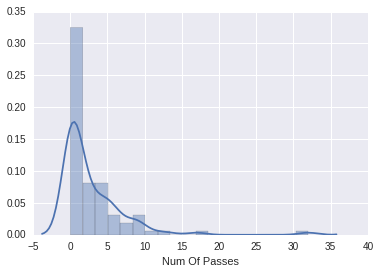

In [482]:
sns.distplot(df1['Num Of Passes'])

## 获得球权后6秒内事件统计

In [813]:
# function to transfer event type id to chinese
dom = etree.parse('/home/endi/Desktop/work/Opta F24 数据/Documentation/Opta_F24_Catalogues.xml').getroot()
def _transfer(dom, type_id):
    if type_id not in [e.attrib['eid'] for e in dom.xpath("//Event")]:
        output = type_id
    else:
        Event = dom.xpath('//Event[@eid="%s"]'%type_id)[0]
        output = Event.attrib['cnName']
    return output, type_id


# transfer player_id to player_name
trans = lambda i: Player_Info.ix[Player_Info.player_id==int(i), 'player_name'].values[0]

In [828]:
#team_id = '357'
#team_name = 'Germany'
#team_id = '368'
#team_name = 'France'
team_id = '359'
team_name = 'Portugal'

sec = 6
record_us = {}
record_opp = {}
total = 0
Players_Involved_defToAtt = {}



start, end = 838507, 838556

# iterate all matches
for match_id in range(start, end+1):
    f = 'euro_2016/F24/f24-3-2015-%d-eventdetails.xml'%match_id
    res = Match(f)
    if res.home_team_id == team_id or res.away_team_id == team_id:
        us, opp, n, players = res.defence_to_attack(team_id, sec)
        for ta_in in players:
            for i in ta_in:
                Players_Involved_defToAtt[i] = Players_Involved_defToAtt.get(i, 0) + 1
        total += n #count how many tackle & interception
        for k,v in us.items():
            record_us[k] = record_us.get(k, 0) + v
        for k,v in opp.items():
            record_opp[k] = record_opp.get(k, 0) + v


# type_id to chinese
_old_key = record_us.keys()
for _k in _old_key:
    cnName, type_id = _transfer(dom, _k.split('_')[0])
    outcome = _k.split('_')[1]
    new_key = cnName + '_' + outcome + ' ' + type_id
    record_us[new_key] = record_us.pop(_k)

_old_key = record_opp.keys()
for _k in _old_key:
    cnName, type_id = _transfer(dom, _k.split('_')[0])
    outcome = _k.split('_')[1]
    new_key = cnName + '_' + outcome + ' ' + type_id
    record_opp[new_key] = record_opp.pop(_k)


##
df_us = pd.DataFrame(sorted(record_us.items(), key=lambda x:x[1], reverse=True))
df_opp = pd.DataFrame(sorted(record_opp.items(), key=lambda x:x[1], reverse=True))

df_us.columns = ['事件类型', '发生次数']
df_opp.columns = ['事件类型', '发生次数']

#
df_us['总计抢断拦截次数'] = total
df_opp['总计抢断拦截次数'] = total

# save
df_us.to_csv('results/tackle_interception_analysis/%s 获得球权 本方行为.csv'%team_name, encoding='utf-8', index=False)
df_opp.to_csv('results/tackle_interception_analysis/%s 获得球权 对方行为.csv'%team_name, encoding='utf-8', index=False)


# 统计球员参与反击次数
df_defToAtt = pd.DataFrame(sorted(Players_Involved_defToAtt.items(), key=lambda x: x[1], reverse=True), columns=['player','参与次数'])
df_defToAtt['player'] = df_defToAtt.player.apply(trans)

df_defToAtt.to_csv('results/tackle_interception_analysis/%s 参与反击次数.csv'%team_name, encoding='utf-8', index=False)

In [829]:
sec = 6
record_us = {}
record_opp = {}
total = 0

Players_Involved_AttToDef = {}


start, end = 838507, 838556

# iterate all matches
for match_id in range(start, end+1):
    f = 'euro_2016/F24/f24-3-2015-%d-eventdetails.xml'%match_id
    res = Match(f)
    if res.home_team_id == team_id or res.away_team_id == team_id:
        us, opp, n, players = res.attack_to_defence(team_id, sec)
        for ta_in in players:
            for i in ta_in:
                Players_Involved_AttToDef[i] = Players_Involved_AttToDef.get(i, 0) + 1
        total += n #count how many tackle & interception
        for k,v in us.items():
            record_us[k] = record_us.get(k, 0) + v
        for k,v in opp.items():
            record_opp[k] = record_opp.get(k, 0) + v


# type_id to chinese
_old_key = record_us.keys()
for _k in _old_key:
    cnName, type_id = _transfer(dom, _k.split('_')[0])
    outcome = _k.split('_')[1]
    new_key = cnName + '_' + outcome + ' ' + type_id
    record_us[new_key] = record_us.pop(_k)

_old_key = record_opp.keys()
for _k in _old_key:
    cnName, type_id = _transfer(dom, _k.split('_')[0])
    outcome = _k.split('_')[1]
    new_key = cnName + '_' + outcome + ' ' + type_id
    record_opp[new_key] = record_opp.pop(_k)


##
df_us = pd.DataFrame(sorted(record_us.items(), key=lambda x:x[1], reverse=True))
df_opp = pd.DataFrame(sorted(record_opp.items(), key=lambda x:x[1], reverse=True))

df_us.columns = ['事件类型', '发生次数']
df_opp.columns = ['事件类型', '发生次数']

#
df_us['总计被抢断拦截次数'] = total
df_opp['总计被抢断拦截次数'] = total

# save
df_us.to_csv('results/tackle_interception_analysis/%s 失去球权 本方行为.csv'%team_name, encoding='utf-8', index=False)
df_opp.to_csv('results/tackle_interception_analysis/%s 失去球权 对方行为.csv'%team_name, encoding='utf-8', index=False)


# 统计球员参与反抢次数
df_attToDef = pd.DataFrame(sorted(Players_Involved_AttToDef.items(), key=lambda x: x[1], reverse=True), columns=['player','参与次数'])
df_attToDef['player'] = df_attToDef.player.apply(trans)

df_attToDef.to_csv('results/tackle_interception_analysis/%s 参与反抢次数.csv'%team_name, encoding='utf-8', index=False)

## 射中球门区域坐标

In [24]:
#team_id = '357'
#team_name = 'Germany'
team_id = '368'
team_name = 'France'
#team_id = '359'
#team_name = 'Portugal'

start, end = 838557, 838557

output = []

for match_id in range(start, end+1):
    f = 'euro_2016/F24/f24-3-2015-%d-eventdetails.xml'%match_id
    res = Match(f)
    if res.home_team_id == team_id or res.away_team_id == team_id:
        output += res.shot_yz(team_id, team_name)

output = pd.DataFrame(output)
output.columns = ['y', 'z']
output.to_csv('results/heatmap/goal_yz/%s.csv'%team_name, index=False, encoding='gbk')

## 防守区域统计 9格图

In [808]:
#team_id = '357'
#team_name = 'Germany'
team_id = '368'
team_name = 'France'
#team_id = '359'
#team_name = 'Portugal'

start, end = 838507, 838556

output = pd.DataFrame({'后场_左路':0, '后场_中路':0, '后场_右路':0, \
                 '中场_左路':0, '中场_中路':0, '中场_右路':0, \
                 '前场_左路':0, '前场_中路':0, '前场_右路':0}, columns=['后场_左路', '后场_中路', '后场_右路', \
                 '中场_左路', '中场_中路', '中场_右路', \
                 '前场_左路', '前场_中路', '前场_右路'], index=[0])

for match_id in range(start, end+1):
    f = 'euro_2016/F24/f24-3-2015-%d-eventdetails.xml'%match_id
    res = Match(f)
    if res.home_team_id == team_id or res.away_team_id == team_id:
        output += pd.DataFrame(res.defence_area(team_id, team_name), columns=['后场_左路', '后场_中路', '后场_右路', \
                 '中场_左路', '中场_中路', '中场_右路', \
                 '前场_左路', '前场_中路', '前场_右路'], index=[0])

#output = pd.DataFrame(output)
#output.columns = ['y', 'z']
output.to_csv('results/heatmap/defence_area/%s.csv'%team_name, index=False, encoding='gbk')

In [791]:
output

,后场_左路,后场_中路,后场_右路,中场_左路,中场_中路,中场_右路,前场_左路,前场_中路,前场_右路
0,51,68,52,22,11,26,2,1,3


In [126]:
# lineups of these matches
start, end = 838507, 838557

for match_id in range(start, end+1):
    f = 'euro_2016/F24/f24-3-2015-%d-eventdetails.xml'%match_id
    res = Match(f)

    print(res.home_team_name, ' vs ', res.away_team_name, ' (match_id:%d)'%match_id)
    print('===========================================================')
    print(res.home_team_name)
    print(res.home_team_lineup.index[0:11].tolist())
    print(res.home_team_lineup.iloc[0:11, ]['number'].tolist())
    print()
    print(res.away_team_name)
    print(res.away_team_lineup.index[0:11].tolist())
    print(res.away_team_lineup.iloc[0:11, ]['number'].tolist())
    print()

France  vs  Romania  (match_id:838507)
France
[37915, 37748, 14075, 116594, 41795, 51507, 74208, 37971, 44346, 76650, 37901]
[1, 19, 3, 5, 4, 21, 15, 14, 9, 7, 8]

Romania
[44898, 40982, 6434, 70085, 62305, 73173, 72244, 81405, 93284, 83289, 56376]
[12, 22, 3, 5, 6, 21, 20, 8, 14, 10, 19]

Albania  vs  Switzerland  (match_id:838508)
Albania
[61824, 107363, 33285, 49980, 16106, 42573, 84360, 84447, 69793, 75763, 84361]
[1, 4, 7, 13, 5, 15, 22, 14, 10, 21, 3]

Switzerland
[34683, 27335, 69305, 84450, 119471, 19160, 68312, 21123, 60841, 32269, 52156]
[1, 2, 13, 10, 22, 20, 23, 11, 9, 15, 18]

Wales  vs  Slovakia  (match_id:838509)
Wales
[95463, 39262, 47390, 115556, 19159, 43252, 16236, 40555, 36903, 103100, 41792]
[21, 2, 3, 4, 6, 5, 14, 7, 11, 20, 10]

Slovakia
[28326, 42614, 28341, 108841, 26793, 26792, 84124, 69143, 67043, 19802, 59306]
[23, 2, 18, 13, 3, 4, 20, 19, 21, 17, 7]

England  vs  Russia  (match_id:838510)
England
[15749, 58621, 38290, 93264, 19419, 55909, 108823, 13017, 788

In [176]:
# 传球后事件统计
#start, end = 838507, 838551
start, end = 838507, 838507

d = {}
for match_id in range(start, end+1):
    f = 'euro_2016/F24/f24-3-2015-%d-eventdetails.xml'%match_id
    res = Match(f)
    for k,v in res.fuck().items():
        d[k] = d.get(k, 0) + v

## 中国vs韩国

In [45]:
#COMP = '友谊赛'
#COMP = '东亚四强赛'
#COMP = '亚洲杯'
#COMP = '友谊赛vs捷克'
#COMP = '友谊赛vs西班牙'
COMP = '四强赛vs中国'

# choose F24 files
if COMP == '友谊赛':
    all_matches = glob('/home/endi/Desktop/work/中国打韩国/韩国/友谊赛/*/*/*.xml')
elif COMP == '东亚四强赛':
    all_matches = glob('/home/endi/Desktop/work/中国打韩国/韩国/东亚四强赛/2015/*/*.xml')
elif COMP == '亚洲杯':
    all_matches = glob('/home/endi/Desktop/work/中国打韩国/韩国/亚洲杯/2014/*/*.xml')
elif COMP == '友谊赛vs捷克':
    all_matches = ['/home/endi/Desktop/work/中国打韩国/韩国/友谊赛/2015/01/捷克1：2韩国-f24-88-2015-848130-eventdetails.xml']
elif COMP == '友谊赛vs西班牙':
    all_matches = ['/home/endi/Desktop/work/中国打韩国/韩国/友谊赛/2015/01/西班牙6：1韩国-f24-88-2015-848129-eventdetails.xml']
elif COMP == '四强赛vs中国':
    all_matches = ['/home/endi/Desktop/work/中国打韩国/韩国/东亚四强赛/2015/01/中国0：2韩国-f24-762-2015-821665-eventdetails.xml']


# choose player_info files
if COMP in ['友谊赛', '友谊赛vs捷克', '友谊赛vs西班牙']:
    Player_Info_1 = pd.read_csv('/home/endi/Desktop/work/中国打韩国/results/player_info_友谊赛2014.csv')
    Player_Info_2 = pd.read_csv('/home/endi/Desktop/work/中国打韩国/results/player_info_友谊赛2015.csv')
    Player_Info = [Player_Info_1, Player_Info_2]
elif COMP in ['东亚四强赛', '四强赛vs中国']:
    Player_Info = pd.read_csv('/home/endi/Desktop/work/中国打韩国/results/player_info_东亚四强赛.csv')
elif COMP == '亚洲杯':
    Player_Info = pd.read_csv('/home/endi/Desktop/work/中国打韩国/results/player_info_亚洲杯.csv')

In [46]:
## cross table of player-to-player-pass
team_id = '1041'
team_name = 'Korea'

passer, receiver = [], []


for f in all_matches:
    res = Match(f)
    if res.home_team_id == team_id or res.away_team_id == team_id:
        output = res.cross_table_passes(team_id)
        passer += output[0]
        receiver += output[1]

# # player real names
# def f(x):
#     try:
#         res = Player_Info.ix[Player_Info.player_id == int(x), 'player_id'].values[0]
#     except:
#         res = 'Unknown'
#     return res

# passer = [Match.player_mapping(i, Player_Info) for i in passer]
# receiver = [Match.player_mapping(i, Player_Info) for i in receiver]

# produce crosstab from two lists
df = pd.DataFrame({'passer':passer, 'receiver':receiver}, columns=['passer', 'receiver'])
count = pd.crosstab(df.passer, df.receiver)
# save
count.to_csv('/home/endi/Desktop/work/中国打韩国/results/传球矩阵/传球矩阵_韩国_%s.csv'%COMP, index=True, encoding='utf-8')

In [47]:
# players' coordinates for touching ball in 5 matches
teams = ['1041']

for f in all_matches:
    res = Match(f)
    home_team, away_team = res.home_team_name, res.away_team_name
    if res.home_team_id not in teams and res.away_team_id not in teams:
        continue
    
    ## home team
    con = zip(res.home_team_lineup.index.tolist(), res.home_team_lineup.number.tolist())
    _l = []
    for player_id, number in con:
    #     print(player_id, number)
        number = str(number)
        player_id = str(player_id)
        output = res.heatMap(number, player_id)
        output['player_id'] = [player_id]*len(output.index)
        output['number'] = [number]*len(output.index)
        output['home_team'] = [home_team]*len(output.index)
        output['match'] = [(home_team, away_team)]*len(output.index)
        _l.append(output)
    pd.concat(_l).to_csv('/home/endi/Desktop/work/中国打韩国/results/player_coordinates/%s, %s vs %s， %s.csv'%\
                         (home_team, home_team, away_team, COMP), index=False, encoding=Coding)
    ## away team
    con = zip(res.away_team_lineup.index.tolist(), res.away_team_lineup.number.tolist())
    _l = []
    for player_id, number in con:
    #     print(player_id, number)
        number = str(number)
        player_id = str(player_id)
        output = res.heatMap(number, player_id)
        output['player_id'] = [player_id]*len(output.index)
        output['number'] = [number]*len(output.index)
        output['away_team'] = [away_team]*len(output.index)
        output['match'] = [(home_team, away_team)]*len(output.index)
        _l.append(output)
    pd.concat(_l).to_csv('/home/endi/Desktop/work/中国打韩国/results/player_coordinates/%s, %s vs %s, %s.csv'%\
                         (away_team, home_team, away_team, COMP), index=False, encoding=Coding)

In [48]:
## 攻防转换 黄金6秒
# function to transfer event type id to chinese
dom = etree.parse('/home/endi/Desktop/work/Opta F24 数据/Documentation/Opta_F24_Catalogues.xml').getroot()
def _transfer(dom, type_id):
    if type_id not in [e.attrib['eid'] for e in dom.xpath("//Event")]:
        output = type_id
    else:
        Event = dom.xpath('//Event[@eid="%s"]'%type_id)[0]
        output = Event.attrib['cnName']
    return output, type_id


# transfer player_id to player_name
trans = lambda i: Player_Info.ix[Player_Info.player_id==int(i), 'player_name'].values[0]

team_id = '1041'
team_name = 'Korea'

##################################
sec = 6
record_us = {}
record_opp = {}
total = 0
Players_Involved_defToAtt = {}


# iterate all matches
for f in all_matches:
    res = Match(f)
    if res.home_team_id == team_id or res.away_team_id == team_id:
        us, opp, n, players = res.defence_to_attack(team_id, sec)
        for ta_in in players:
            for i in ta_in:
                Players_Involved_defToAtt[i] = Players_Involved_defToAtt.get(i, 0) + 1
        total += n #count how many tackle & interception
        for k,v in us.items():
            record_us[k] = record_us.get(k, 0) + v
        for k,v in opp.items():
            record_opp[k] = record_opp.get(k, 0) + v


# type_id to chinese
_old_key = record_us.keys()
for _k in _old_key:
    cnName, type_id = _transfer(dom, _k.split('_')[0])
    outcome = _k.split('_')[1]
    new_key = cnName + '_' + outcome + ' ' + type_id
    record_us[new_key] = record_us.pop(_k)

_old_key = record_opp.keys()
for _k in _old_key:
    cnName, type_id = _transfer(dom, _k.split('_')[0])
    outcome = _k.split('_')[1]
    new_key = cnName + '_' + outcome + ' ' + type_id
    record_opp[new_key] = record_opp.pop(_k)


##
df_us = pd.DataFrame(sorted(record_us.items(), key=lambda x:x[1], reverse=True))
df_opp = pd.DataFrame(sorted(record_opp.items(), key=lambda x:x[1], reverse=True))

df_us.columns = ['事件类型', '发生次数']
df_opp.columns = ['事件类型', '发生次数']

#
df_us['总计抢断拦截次数'] = total
df_opp['总计抢断拦截次数'] = total

# save
df_us.to_csv('/home/endi/Desktop/work/中国打韩国/results/攻防转换黄金6秒/%s 获得球权 本方行为_%s.csv'%(team_name, COMP), encoding='utf-8', index=False)
df_opp.to_csv('/home/endi/Desktop/work/中国打韩国/results/攻防转换黄金6秒/%s 获得球权 对方行为_%s.csv'%(team_name, COMP), encoding='utf-8', index=False)


# 统计球员参与反击次数
df_defToAtt = pd.DataFrame(sorted(Players_Involved_defToAtt.items(), key=lambda x: x[1], reverse=True), columns=['player','参与次数'])
df_defToAtt['player'] = [Match.player_mapping(int(i), Player_Info)[1] for i in df_defToAtt.player]

df_defToAtt.to_csv('/home/endi/Desktop/work/中国打韩国/results/攻防转换黄金6秒/%s 参与反击次数_%s.csv'%(team_name, COMP), encoding='utf-8', index=False)


##################################
sec = 6
record_us = {}
record_opp = {}
total = 0

Players_Involved_AttToDef = {}


# iterate all matches
for f in all_matches:
    res = Match(f)
    if res.home_team_id == team_id or res.away_team_id == team_id:
        us, opp, n, players = res.attack_to_defence(team_id, sec)
        for ta_in in players:
            for i in ta_in:
                Players_Involved_AttToDef[i] = Players_Involved_AttToDef.get(i, 0) + 1
        total += n #count how many tackle & interception
        for k,v in us.items():
            record_us[k] = record_us.get(k, 0) + v
        for k,v in opp.items():
            record_opp[k] = record_opp.get(k, 0) + v


# type_id to chinese
_old_key = record_us.keys()
for _k in _old_key:
    cnName, type_id = _transfer(dom, _k.split('_')[0])
    outcome = _k.split('_')[1]
    new_key = cnName + '_' + outcome + ' ' + type_id
    record_us[new_key] = record_us.pop(_k)

_old_key = record_opp.keys()
for _k in _old_key:
    cnName, type_id = _transfer(dom, _k.split('_')[0])
    outcome = _k.split('_')[1]
    new_key = cnName + '_' + outcome + ' ' + type_id
    record_opp[new_key] = record_opp.pop(_k)


##
df_us = pd.DataFrame(sorted(record_us.items(), key=lambda x:x[1], reverse=True))
df_opp = pd.DataFrame(sorted(record_opp.items(), key=lambda x:x[1], reverse=True))

df_us.columns = ['事件类型', '发生次数']
df_opp.columns = ['事件类型', '发生次数']

#
df_us['总计被抢断拦截次数'] = total
df_opp['总计被抢断拦截次数'] = total

# save
df_us.to_csv('/home/endi/Desktop/work/中国打韩国/results/攻防转换黄金6秒/%s 失去球权 本方行为_%s.csv'%(team_name, COMP), encoding='utf-8', index=False)
df_opp.to_csv('/home/endi/Desktop/work/中国打韩国/results/攻防转换黄金6秒/%s 失去球权 对方行为_%s.csv'%(team_name, COMP), encoding='utf-8', index=False)


# 统计球员参与反抢次数
df_attToDef = pd.DataFrame(sorted(Players_Involved_AttToDef.items(), key=lambda x: x[1], reverse=True), columns=['player','参与次数'])
df_attToDef['player'] = [Match.player_mapping(int(i), Player_Info)[1] for i in df_attToDef.player]

df_attToDef.to_csv('/home/endi/Desktop/work/中国打韩国/results/攻防转换黄金6秒/%s 参与反抢次数_%s.csv'%(team_name, COMP), encoding='utf-8', index=False)


In [50]:
# 防守区域9格
output = pd.DataFrame({'后场_左路':0, '后场_中路':0, '后场_右路':0, \
                 '中场_左路':0, '中场_中路':0, '中场_右路':0, \
                 '前场_左路':0, '前场_中路':0, '前场_右路':0}, columns=['后场_左路', '后场_中路', '后场_右路', \
                 '中场_左路', '中场_中路', '中场_右路', \
                 '前场_左路', '前场_中路', '前场_右路'], index=[0])

for f in all_matches:
    res = Match(f)
    if res.home_team_id == team_id or res.away_team_id == team_id:
        output += pd.DataFrame(res.defence_area(team_id, team_name), columns=['后场_左路', '后场_中路', '后场_右路', \
                 '中场_左路', '中场_中路', '中场_右路', \
                 '前场_左路', '前场_中路', '前场_右路'], index=[0])

#output = pd.DataFrame(output)
#output.columns = ['y', 'z']
output.to_csv('/home/endi/Desktop/work/中国打韩国/results/防守区域/防守区域_%s_%s.csv'%(team_name, COMP), index=False, encoding='utf-8')

In [51]:
# 射门过程统计
for f in all_matches:
    res = Match(f)
    res.goal_trace(team_id, team_name, '/home/endi/Desktop/work/中国打韩国/results/射门过程统计/%s/'%COMP)


_files = glob('/home/endi/Desktop/work/中国打韩国/results/射门过程统计/%s/*.csv'%COMP)


passes = []
periods = []
players = []
outcome = []

for _f in _files:
    team = _f.split('/')[-1].split(' ')[0]
    if team == team_name:
        df = pd.read_csv(_f)
        if len(df.index) > 1:# >1 有配合的射门
            passes.append((df['type'] == 'pass').sum())
            periods.append((df['min'].iloc[-1] - df['min'].iloc[0])*60 + (df['sec'].iloc[-1] - df['sec'].iloc[0]))
            players.append(len(df.player_id.unique()))
            outcome.append(df.iloc[-1]['type'])

report = pd.DataFrame({'Num Of Passes':passes, 'Length Of Attack(sec)':periods, 'Players Involved':players, 'Outcome':outcome}, \
                     columns=['Num Of Passes', 'Length Of Attack(sec)', 'Players Involved', 'Outcome'])

report.to_csv('/home/endi/Desktop/work/中国打韩国/results/射门过程统计/韩国_%s.csv'%COMP, index=False)